In [ ]:
# Libraries
import os
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from os import listdir
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings
import numpy as np
import matplotlib.patches as patches


In [1]:
def path(ssd_loc):
    dir_path = os.path.join(base_location, ssd_loc)
    return dir_path

base_location = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection'

In [2]:
# train.csv - contains metadata for train_images.
train_df = pd.read_csv(path('train.csv'))

# StudyInstanceUID - The study ID. There is one unique study ID for each patient scan.
# patient_overall - The patient level outcome, i.e. if any of the vertebrae are fractured.
# C[1-7] - Whether the given vertebrae is fractured.
train_df.head(3)

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0

In [3]:
# train_bounding_boxes.csv - contains bounding boxes of where fractures occured for a subset of the training set.
train_bbox = pd.read_csv(path('train_bounding_boxes.csv'))

# StudyInstanceUID - The study ID. There is one unique study ID for each patient scan.
# x - x-coordinate of bounding box bottom left corner
# y - y-coordinate of bounding box bottom left corner
# width - width of bounding box
# height - height of bounding box
# slice_number - slice number of scan
train_bbox.head(3)

StudyInstanceUID          x          y     width    height  \
0  1.2.826.0.1.3680043.10051  219.27715  216.71419  17.30440  20.38517   
1  1.2.826.0.1.3680043.10051  221.56460  216.71419  17.87844  25.24362   
2  1.2.826.0.1.3680043.10051  216.82151  221.62546  27.00959  26.37454   

   slice_number  
0           133  
1           134  
2           135

In [4]:
# test.csv - contains metadata for test_images.
test_df = pd.read_csv(path('test.csv'))

# row_id - The row ID. This will match the same column in the sample submission file.
# StudyInstanceUID - The study ID.
# prediction_type - Which one of the eight target columns needs a prediction in this row.
train_bbox.head(3)

StudyInstanceUID          x          y     width    height  \
0  1.2.826.0.1.3680043.10051  219.27715  216.71419  17.30440  20.38517   
1  1.2.826.0.1.3680043.10051  221.56460  216.71419  17.87844  25.24362   
2  1.2.826.0.1.3680043.10051  216.82151  221.62546  27.00959  26.37454   

   slice_number  
0           133  
1           134  
2           135

In [5]:
# sample_submission.csv** - A valid sample submission.
submission_df = pd.read_csv(path('sample_submission.csv'))

# row_id - The row ID. See the test.csv for what prediction needs to be filed in that row.
# fracture - The target column.
submission_df.head(3)

row_id  fractured
0  1.2.826.0.1.3680043.10197_C1        0.5
1  1.2.826.0.1.3680043.10454_C1        0.5
2  1.2.826.0.1.3680043.10690_C1        0.5

In [6]:
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.5.3


(0.0, 2800.0)

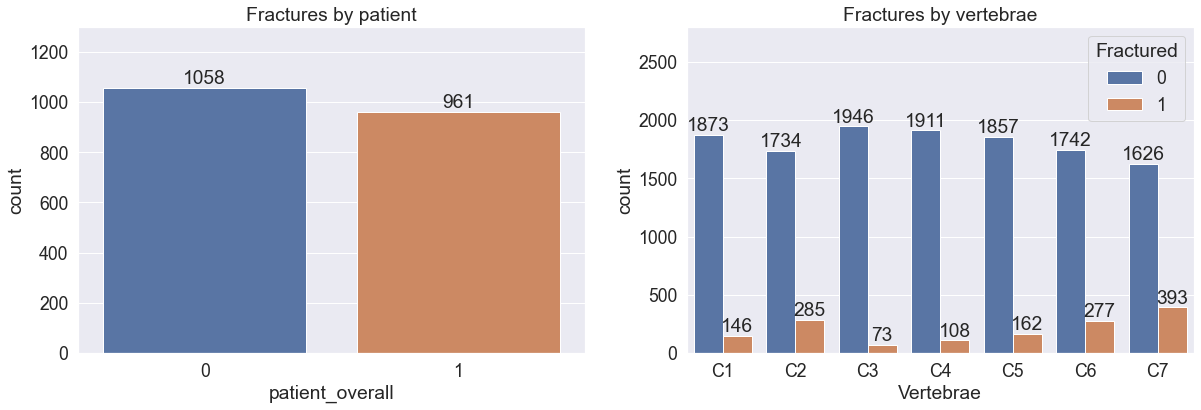

In [7]:
sns.set(style='darkgrid', font_scale=1.6)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])

# Unpivot train_df for plotting
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])


(0.0, 1300.0)

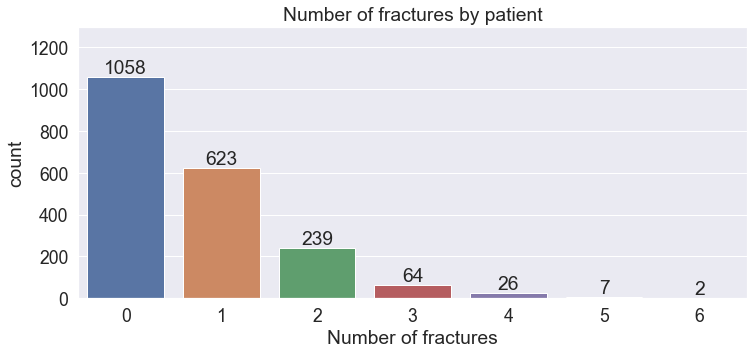

In [8]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')
plt.ylim([0,1300])

In [10]:
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")
train_melt # 2019*7 = 14,133

StudyInstanceUID  patient_overall Vertebrae  Fractured
0       1.2.826.0.1.3680043.6200                1        C1          1
1      1.2.826.0.1.3680043.27262                1        C1          0
2      1.2.826.0.1.3680043.21561                1        C1          0
3      1.2.826.0.1.3680043.12351                0        C1          0
4       1.2.826.0.1.3680043.1363                1        C1          0
...                          ...              ...       ...        ...
14128  1.2.826.0.1.3680043.21684                1        C7          1
14129   1.2.826.0.1.3680043.4786                1        C7          1
14130  1.2.826.0.1.3680043.14341                0        C7          0
14131  1.2.826.0.1.3680043.12053                0        C7          0
14132  1.2.826.0.1.3680043.18786                1        C7          1

[14133 rows x 4 columns]

In [11]:
train_df.head(3)

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0

In [12]:
train_df['StudyInstanceUID'][0]

'1.2.826.0.1.3680043.6200'

In [13]:
# Find unique numbers in study id's
for i in range(7):
    print(train_df['StudyInstanceUID'].map(lambda x : x.split('.')[i]).unique())

['1']
['2']
['826']
['0']
['1']
['3680043']
['6200' '27262' '21561' ... '14341' '12053' '18786']


In [15]:
ex_path = "/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001/101.dcm"
dcm_example = pydicom.dcmread(ex_path)
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10001.1.101
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10001.1.101
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '175846.512627'
(0010, 0010) Patient's Name                      PN: '10001'
(0010, 0020) Patient ID                          LO: '10001'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

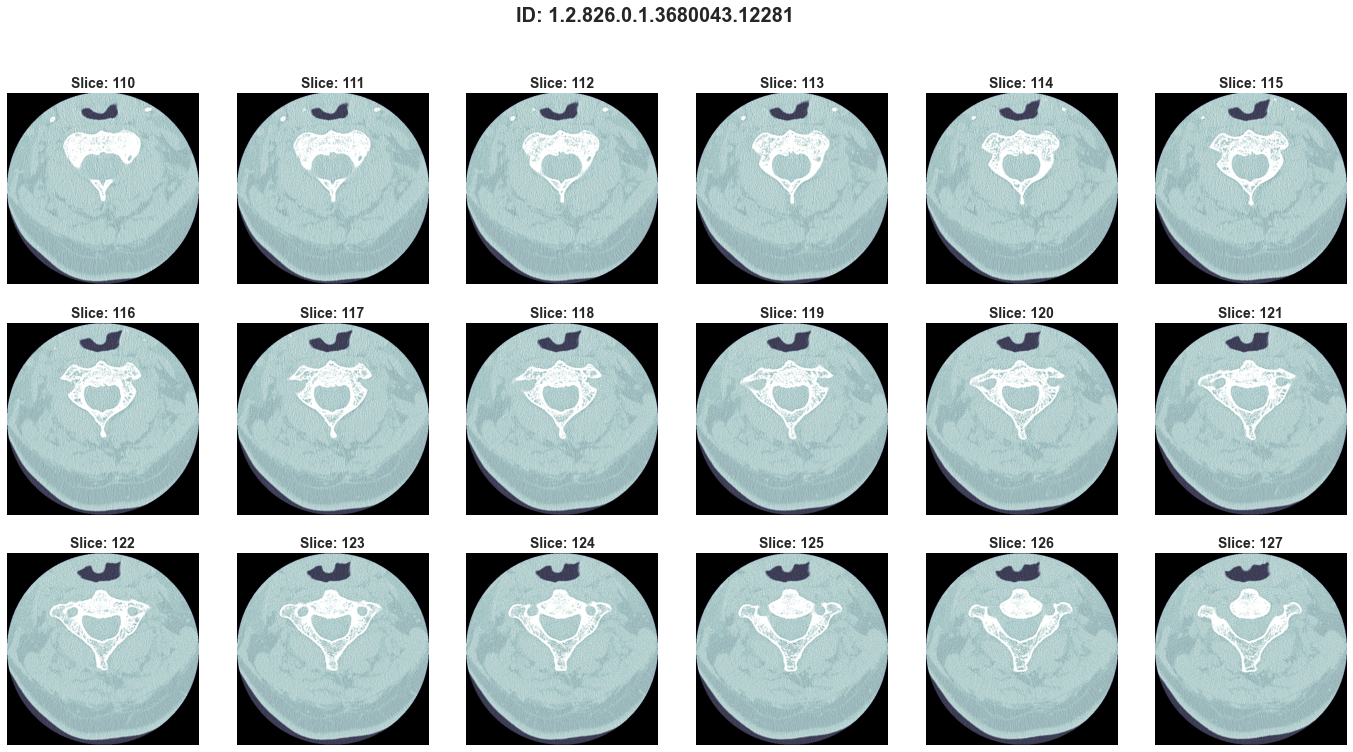

In [16]:
# Adapted from https://www.kaggle.com/code/andradaolteanu/rsna-fracture-detection-dicom-images-explore
patient_id = '1.2.826.0.1.3680043.12281'
# patient_id = '1.2.826.0.1.3680043.1573'
dcm_paths = glob(f"{base_location}/train_images/{patient_id}/*")
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]
dcm_paths.sort(key=natural_keys)

# Get images
files = [pydicom.dcmread(path) for path in dcm_paths]
images = [apply_voi_lut(file.pixel_array, file) for file in files]

# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

start = 110
for i in range(start,start+18):
    img = images[i]
    file = files[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [17]:
ex_path2 = f"{base_location}/segmentations/{patient_id}.nii"
nii_example = nib.load(ex_path2)

# Convert to numpy array
seg = nii_example.get_fdata()
seg.shape

(512, 512, 331)

In [18]:
# Align orientation with images
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
seg.shape

(331, 512, 512)

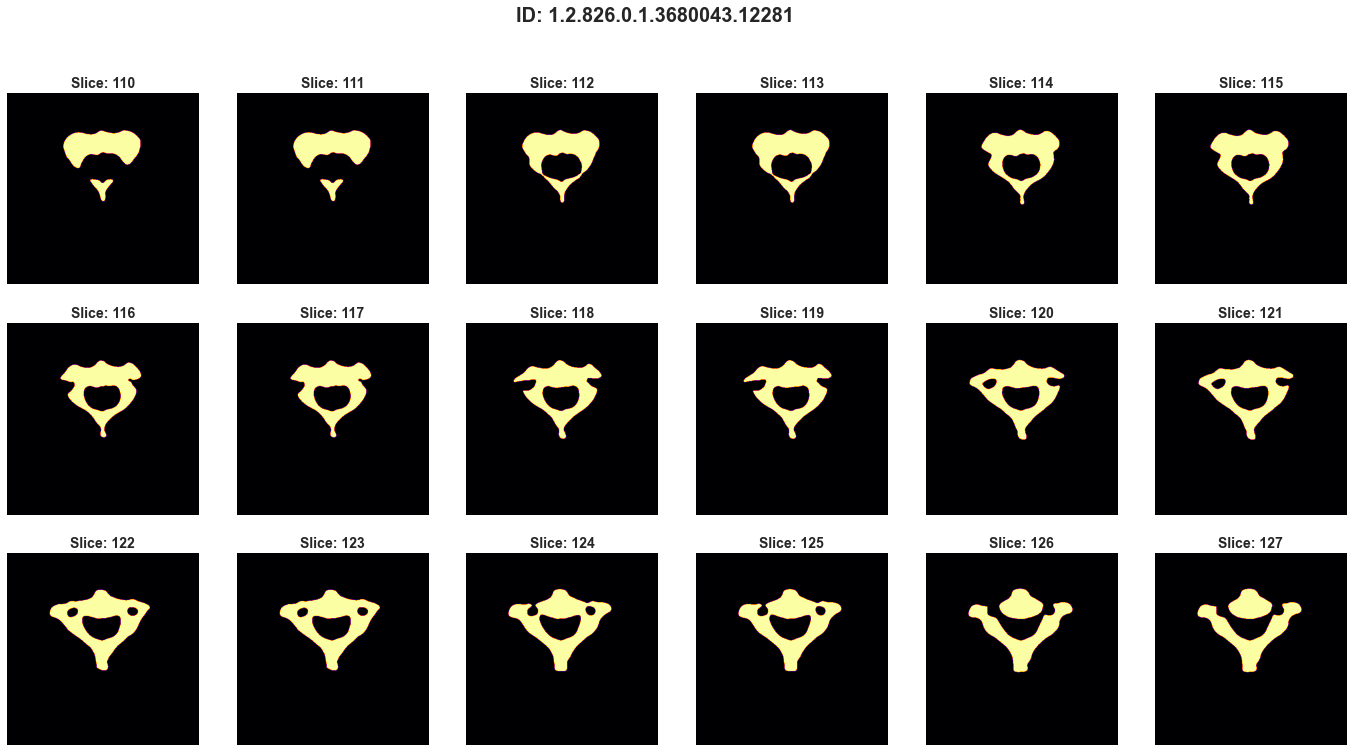

In [19]:
# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

for i in range(start,start+18):
    mask = seg[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='inferno')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [20]:
np.unique(seg[127])

array([0., 2.])

In [24]:
def get_observation_data(path):
    '''
    Get information from the .dcm files
    '''

    dataset = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "Rows" : dataset.get("Rows"),
        "Columns" : dataset.get("Columns"),
        "SOPInstanceUID" : dataset.get("SOPInstanceUID"),
        "ContentDate" : dataset.get("ContentDate"),
        "SliceThickness" : dataset.get("SliceThickness"),
        "InstanceNumber" : dataset.get("InstanceNumber"),
        "ImagePositionPatient" : dataset.get("ImagePositionPatient"),
        "ImageOrientationPatient" : dataset.get("ImageOrientationPatient"),
    }

    # String columns
    str_columns = ["SOPInstanceUID", "ContentDate", 
                   "SliceThickness", "InstanceNumber"]
    for k in str_columns:
        observation_data[k] = str(dataset.get(k)) if k in dataset else None

    return observation_data

In [25]:
md_example = get_observation_data(ex_path)
pprint(md_example)

{'Columns': 512,
 'ContentDate': '20220727',
 'ImageOrientationPatient': [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000],
 'ImagePositionPatient': [-52.308, -27.712, -55.218],
 'InstanceNumber': '101',
 'Rows': 512,
 'SOPInstanceUID': '1.2.826.0.1.3680043.10001.1.101',
 'SliceThickness': '0.625000'}


In [27]:
print(len(train_df))

2019


In [28]:
train_df.iloc[1, :]

StudyInstanceUID    1.2.826.0.1.3680043.27262
patient_overall                             1
C1                                          0
C2                                          1
C3                                          0
C4                                          0
C5                                          0
C6                                          0
C7                                          0
Name: 1, dtype: object

In [29]:
def get_metadata():
    '''
    Retrieves the desired metadata from the .dcm files and saves it into dataframe.
    '''
    
    exceptions = 0
    dicts = []

    for k in tqdm(range(len(train_df))):
        if (k % 100)==0:
            print(f'Iteration: {k}')
            
        dt = train_df.iloc[k, :]

        # Get all .dcm paths for this Instance
        dcm_paths = glob(f"{base_location}/train_images/{dt.StudyInstanceUID}/*")

        for path in dcm_paths:
            try:
                # Get datasets
                dataset = get_observation_data(path)
                dicts.append(dataset)
            except Exception as e:
                exceptions += 1
                continue

    # Convert into df
    meta_train_data = pd.DataFrame(data=dicts, columns=md_example.keys())
    
    # Export information
    meta_train_data.to_csv("meta_train.csv", index=False)
    
    print(f"Metadata created. Number of total fails: {exceptions}.")

In [31]:
get_metadata()

  0%|          | 0/2019 [00:00<?, ?it/s]

Iteration: 0


  5%|▍         | 100/2019 [01:34<26:51,  1.19it/s]

Iteration: 100


 10%|▉         | 200/2019 [03:45<26:30,  1.14it/s]  

Iteration: 200


 15%|█▍        | 300/2019 [05:20<23:00,  1.24it/s]

Iteration: 300


 20%|█▉        | 400/2019 [07:35<1:10:33,  2.61s/it]

Iteration: 400


 25%|██▍       | 500/2019 [11:42<24:55,  1.02it/s]  

Iteration: 500


 30%|██▉       | 600/2019 [13:35<21:04,  1.12it/s]

Iteration: 600


 35%|███▍      | 700/2019 [15:29<29:22,  1.34s/it]  

Iteration: 700


 40%|███▉      | 800/2019 [18:13<20:55,  1.03s/it]  

Iteration: 800


 45%|████▍     | 900/2019 [20:51<17:28,  1.07it/s]  

Iteration: 900


 50%|████▉     | 1000/2019 [23:17<1:18:14,  4.61s/it]

Iteration: 1000


 54%|█████▍    | 1100/2019 [26:48<14:22,  1.07it/s]  

Iteration: 1100


 59%|█████▉    | 1200/2019 [28:29<12:42,  1.07it/s]

Iteration: 1200


 64%|██████▍   | 1300/2019 [30:25<15:19,  1.28s/it]

Iteration: 1300


 69%|██████▉   | 1400/2019 [32:27<11:51,  1.15s/it]

Iteration: 1400


 74%|███████▍  | 1500/2019 [34:25<09:22,  1.08s/it]

Iteration: 1500


 79%|███████▉  | 1600/2019 [36:18<06:45,  1.03it/s]

Iteration: 1600


 84%|████████▍ | 1700/2019 [40:00<27:59,  5.27s/it]

Iteration: 1700


 89%|████████▉ | 1800/2019 [43:22<03:54,  1.07s/it]

Iteration: 1800


 94%|█████████▍| 1900/2019 [46:08<02:33,  1.29s/it]

Iteration: 1900


 99%|█████████▉| 2000/2019 [48:11<00:22,  1.17s/it]

Iteration: 2000


100%|██████████| 2019/2019 [48:35<00:00,  1.44s/it]


Metadata created. Number of total fails: 0.


In [32]:
meta_train = pd.read_csv(path('meta_train.csv'))
meta_train["StudyInstanceUID"] = meta_train['SOPInstanceUID'].apply(lambda x: '.'.join(x.split(".")[:-2]))
print('meta_train shape:', meta_train.shape)
meta_train.head(3)

meta_train shape: (711601, 9)


Rows  Columns                  SOPInstanceUID  ContentDate  SliceThickness  \
0   512      512    1.2.826.0.1.3680043.6200.1.1     20220727             1.0   
1   512      512   1.2.826.0.1.3680043.6200.1.10     20220727             1.0   
2   512      512  1.2.826.0.1.3680043.6200.1.100     20220727             1.0   

   InstanceNumber           ImagePositionPatient  \
0               1  [-118.530, -103.5302, 334.50]   
1              10  [-118.530, -103.5302, 327.30]   
2             100  [-118.530, -103.5302, 255.30]   

                             ImageOrientationPatient          StudyInstanceUID  
0  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  1.2.826.0.1.3680043.6200  
1  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  1.2.826.0.1.3680043.6200  
2  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  1.2.826.0.1.3680043.6200

Text(0.5, 1, 'Image sizes in train images')

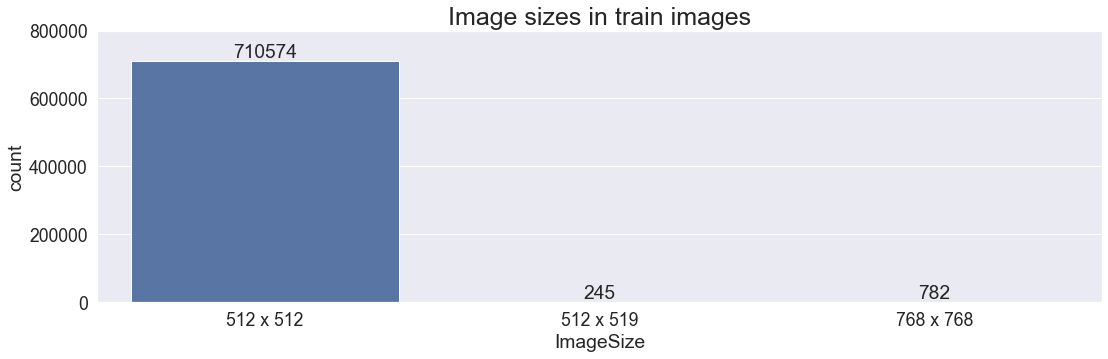

In [37]:
meta_train["ImageSize"] = meta_train["Rows"].astype(str) + " x " + meta_train["Columns"].astype(str)

# Plot image sizes
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train, x="ImageSize")
for container in ax.containers:
    ax.bar_label(container)
plt.ylim([0,800000])
plt.title('Image sizes in train images', fontsize=25, y=1)

In [38]:
meta_train['ContentDate'].unique() # can be dropped

array([20220727])

In [39]:
meta_train.drop('ContentDate', axis=1, inplace=True)

In [43]:
meta_train["SliceThickness"].unique()

array([1.        , 0.5       , 0.625     , 0.6       , 0.67      ,
       0.9       , 0.8       , 0.488281  , 0.75      , 0.664062  ,
       0.60000002])

In [53]:
x = meta_train["SliceThickness"].unique()
x.sort()
y = list(map(str, x))
print(y)

['0.488281', '0.5', '0.6', '0.6000000238', '0.625', '0.664062', '0.67', '0.75', '0.8', '0.9', '1.0']


Text(0.5, 1.02, 'Slice thickness distribution')

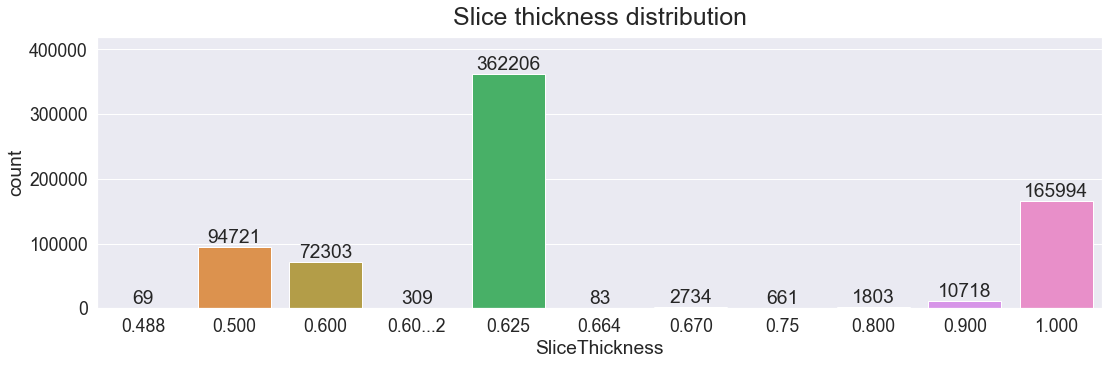

In [54]:
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train, x="SliceThickness")
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels(['0.488','0.500','0.600','0.60...2','0.625','0.664','0.670','0.75','0.800','0.900','1.000'])
plt.ylim([0,420000])
plt.title('Slice thickness distribution', fontsize=25, y=1.02)

Text(0.5, 0, 'Number of Slices')

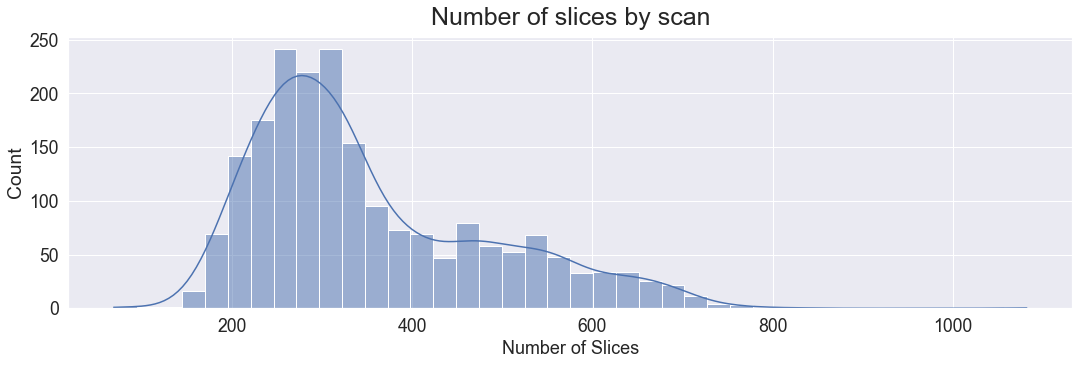

In [58]:
slice_counts = meta_train["StudyInstanceUID"].value_counts().reset_index()
slice_counts.columns = ["StudyInstanceUID", "count"]

plt.figure(figsize=(18, 5))
sns.histplot(data=slice_counts, x="count", kde=True, bins=40)
plt.title("Number of slices by scan", size=25, y=1.02)
plt.xlabel("Number of Slices", size = 18)

In [64]:
meta_train['ImagePositionPatient_x'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[0]))
meta_train['ImagePositionPatient_y'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[1]))
meta_train['ImagePositionPatient_z'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[2]))

Text(0.5, 1.02, 'z-coordinate')

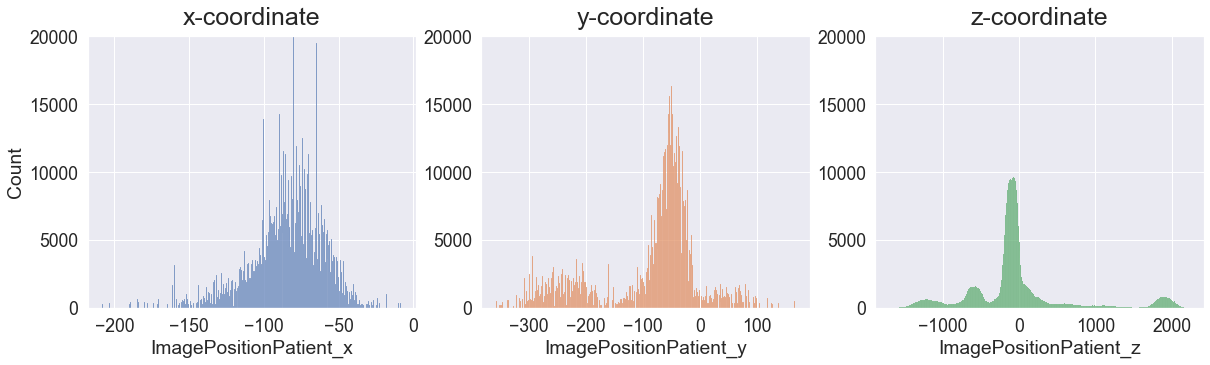

In [67]:
# Plot position coordinates
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(meta_train['ImagePositionPatient_x'])
plt.ylim([0,20000])
plt.title('x-coordinate', fontsize=25, y=1.02)

plt.subplot(1,3,2)
sns.histplot(meta_train['ImagePositionPatient_y'], color='C1')
plt.ylabel('')
plt.ylim([0,20000])
plt.title('y-coordinate', fontsize=25, y=1.02)

plt.subplot(1,3,3)
sns.histplot(meta_train['ImagePositionPatient_z'], color='C2')
plt.ylabel('')
plt.ylim([0,20000])
plt.title('z-coordinate', fontsize=25, y=1.02)

In [68]:
meta_train['ImageOrientationPatient'].nunique() # can be dropped

400

In [69]:
meta_train_clean = meta_train.drop(['SOPInstanceUID','ImagePositionPatient','ImageOrientationPatient','ImageSize'], axis=1)
meta_train_clean.rename(columns={"Rows": "ImageHeight", "Columns": "ImageWidth","InstanceNumber": "Slice"}, inplace=True)
meta_train_clean = meta_train_clean[['StudyInstanceUID','Slice','ImageHeight','ImageWidth','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']]
meta_train_clean.sort_values(by=['StudyInstanceUID','Slice'], inplace=True)
meta_train_clean.reset_index(drop=True, inplace=True)

meta_train_clean.to_csv("meta_train_clean.csv", index=False)

meta_train_clean.head(3)

StudyInstanceUID  Slice  ImageHeight  ImageWidth  SliceThickness  \
0  1.2.826.0.1.3680043.10001      1          512         512           0.625   
1  1.2.826.0.1.3680043.10001      2          512         512           0.625   
2  1.2.826.0.1.3680043.10001      3          512         512           0.625   

   ImagePositionPatient_x  ImagePositionPatient_y  ImagePositionPatient_z  
0                 -52.308                 -27.712                   7.282  
1                 -52.308                 -27.712                   6.657  
2                 -52.308                 -27.712                   6.032

# 7. Bounding boxes


In [71]:
print(f'Patients with bounding box measurements: {train_bbox["StudyInstanceUID"].nunique()} ({np.round(100*train_bbox["StudyInstanceUID"].nunique()/len(train_df),1)} %)')

Patients with bounding box measurements: 235 (11.6 %)


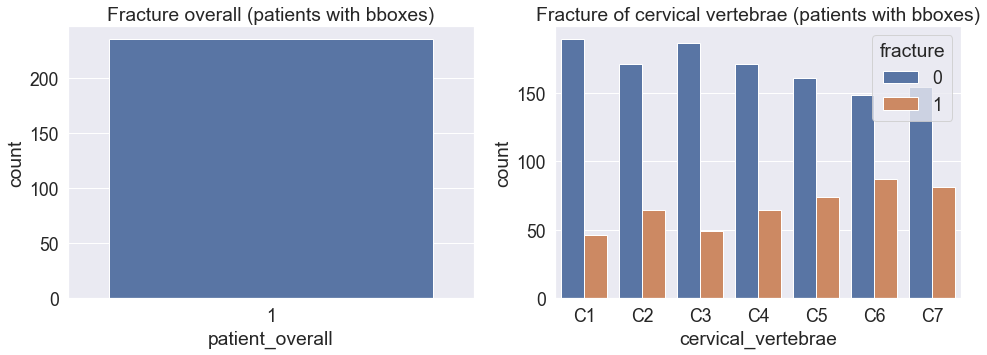

In [72]:
train_df_bbox = train_df[train_df["StudyInstanceUID"].isin(train_bbox["StudyInstanceUID"])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x="patient_overall", data=train_df_bbox, ax=ax1)
ax1.set_title("Fracture overall (patients with bboxes)")

train_df_bbox_melt = pd.melt(train_df_bbox, id_vars=["StudyInstanceUID", "patient_overall"], var_name="cervical_vertebrae", value_name="fracture")
sns.countplot(x="cervical_vertebrae", hue="fracture", data=train_df_bbox_melt, ax=ax2)
ax2.set_title("Fracture of cervical vertebrae (patients with bboxes)")
plt.show()

Text(0.5, 0, 'Number of bboxes')

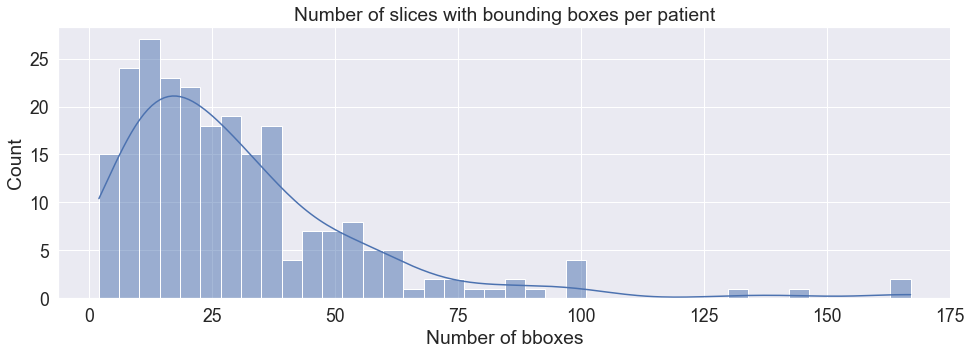

In [73]:
plt.figure(figsize=(16,5))
sns.histplot(train_bbox["StudyInstanceUID"].value_counts().values, kde=True, bins=40)
plt.title('Number of slices with bounding boxes per patient')
plt.xlabel('Number of bboxes')

Text(0.5, 1.0, 'Width and heights')

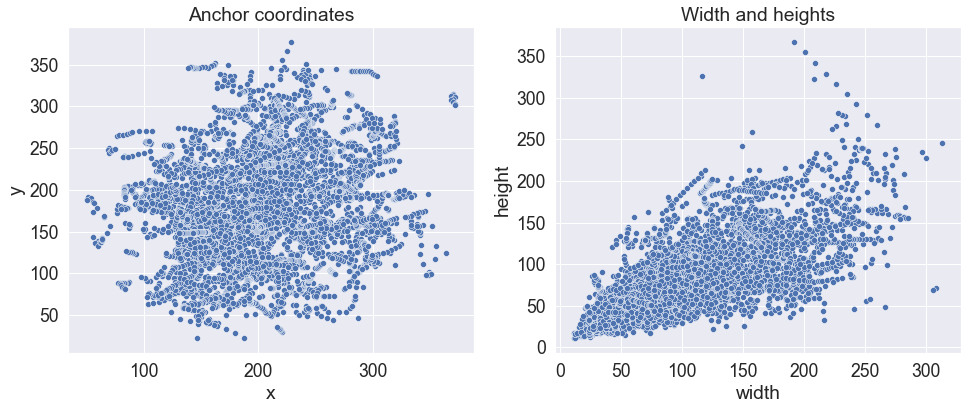

In [74]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(data=train_bbox, x='x', y='y')
plt.title('Anchor coordinates')

plt.subplot(1,2,2)
sns.scatterplot(data=train_bbox, x='width', y='height')
plt.title('Width and heights')

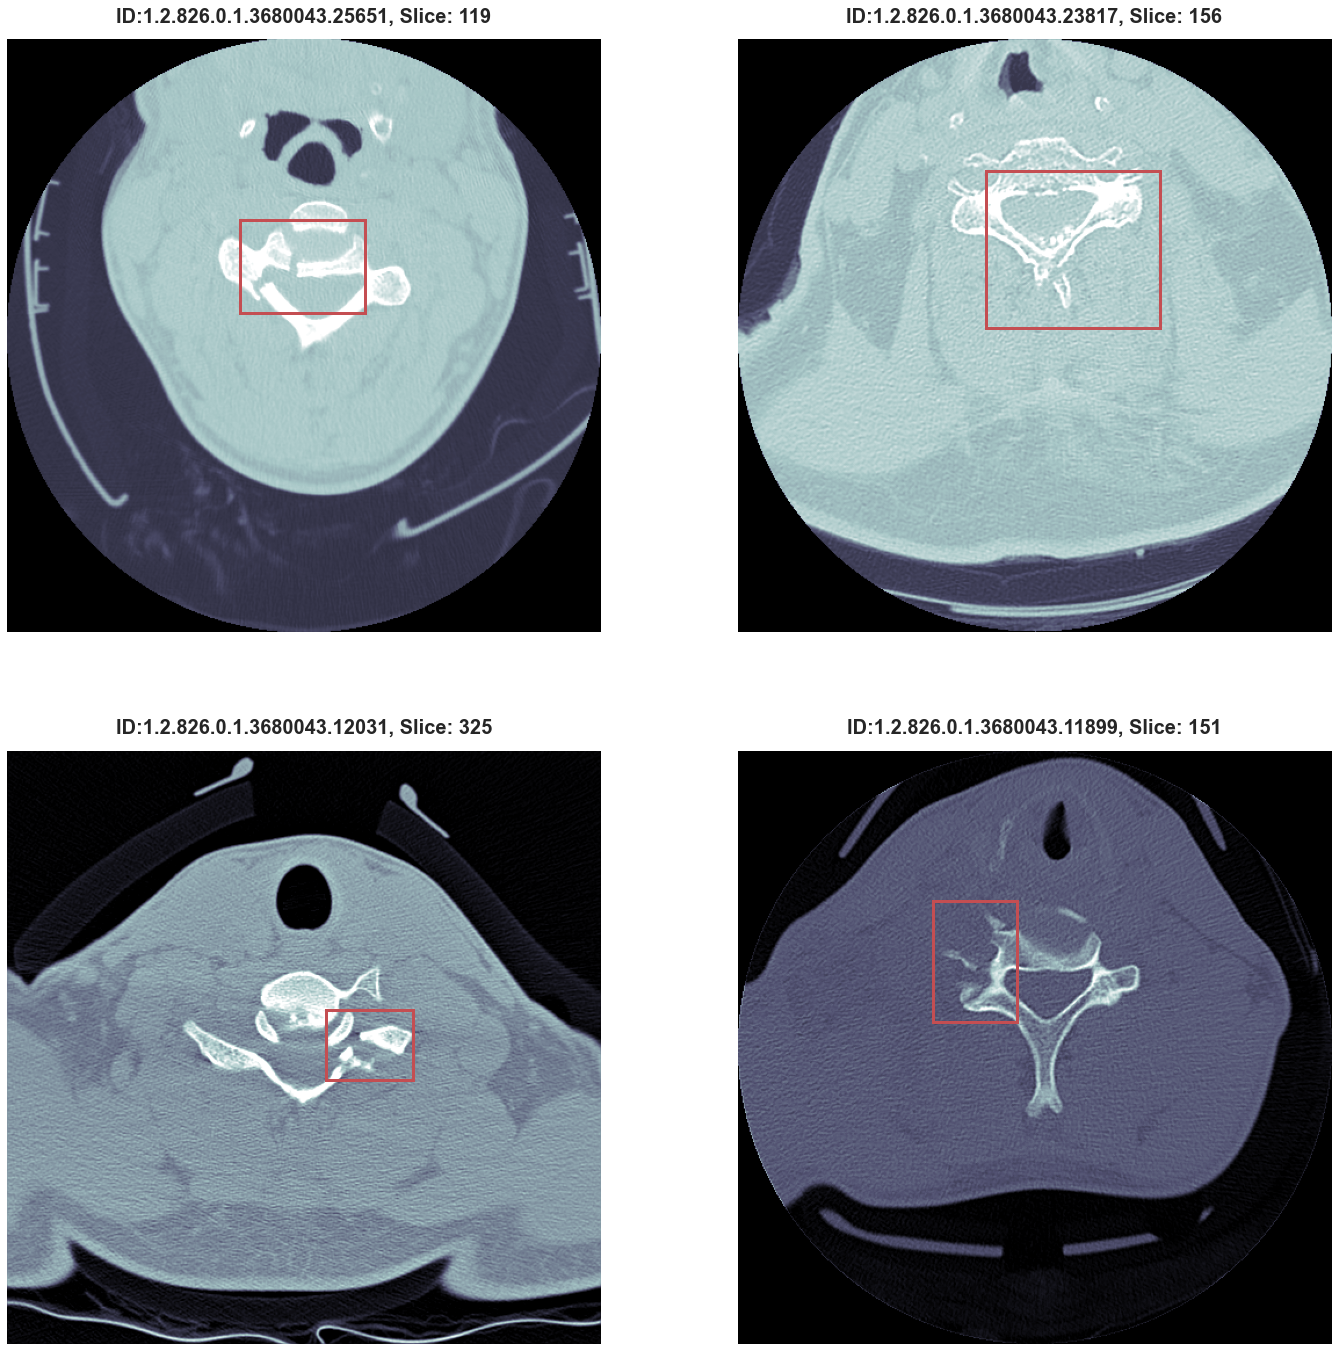

In [75]:
def plot_fracture(slice_num,bbox_id,ax_id1,ax_id2):
    file = pydicom.dcmread(f"{base_location}/train_images/{bbox_id}/{slice_num}.dcm")
    img = apply_voi_lut(file.pixel_array, file)
    info = train_bbox[(train_bbox['StudyInstanceUID']==bbox_id)&(train_bbox['slice_number']==slice_num)]
    rect = patches.Rectangle((float(info.x), float(info.y)), float(info.width), float(info.height), linewidth=3, edgecolor='r', facecolor='none')

    axes[ax_id1,ax_id2].imshow(img, cmap="bone")
    axes[ax_id1,ax_id2].add_patch(rect)
    axes[ax_id1,ax_id2].set_title(f"ID:{bbox_id}, Slice: {slice_num}", fontsize=20, weight='bold',y=1.02)
    axes[ax_id1,ax_id2].axis('off')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,24))
plot_fracture(119,'1.2.826.0.1.3680043.25651',0,0)
plot_fracture(156,'1.2.826.0.1.3680043.23817',0,1)
plot_fracture(325,'1.2.826.0.1.3680043.12031',1,0)
plot_fracture(151,'1.2.826.0.1.3680043.11899',1,1)